In [1]:
from typing import Annotated 
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages # ----> reducer
from dotenv import load_dotenv
from langgraph.prebuilt import ToolNode, tools_condition
import os

load_dotenv()

google_api_key = os.getenv("GOOGLE_API_KEY")
tavily_api_key = os.getenv("TAVILY_API_KEY")
os.environ["GOOGLE_API_KEY"] = google_api_key
os.environ["TAVILY_API_KEY"] = tavily_api_key 
from langchain_tavily import TavilySearch

tool = TavilySearch(
    max_results=2
    #topic="general",
    # include_answer=False,
    # include_raw_content=False,
    # include_images=False,
    # include_image_descriptions=False,
    # search_depth="basic",
    # time_range="day",
    # include_domains=None,
    # exclude_domains=None
)

In [2]:
from langchain.chat_models import init_chat_model
llm = init_chat_model("google_genai:gemini-2.0-flash")

E0000 00:00:1760356906.321777   42863 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


In [3]:
def multiply(a: int, b: int) -> int:
    """Multiplies two numbers.
    Args:
        a (int): The first number.
        b (int): The second number.
    Returns:
        int: The product of the two numbers.
    """
    return a * b

In [4]:
from typing import Annotated

from langchain_tavily import TavilySearch
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

tool = TavilySearch(max_results=2)
tools = [tool, multiply]
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
#graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("tools", END)
graph = graph_builder.compile()

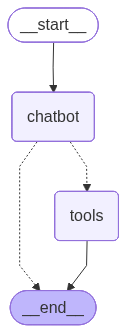

In [ ]:


from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [6]:
response = graph.invoke({"messages": "What is the recent news about AI?"})
response['messages'][-1].content

'{"query": "recent AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.reuters.com/business/openai-declares-huge-focus-enterprise-growth-with-array-partnerships-2025-10-06/", "title": "OpenAI declares \'huge focus\' on enterprise growth with array of partnerships - Reuters", "score": 0.6628188, "published_date": "Mon, 06 Oct 2025 20:59:10 GMT", "content": "SAN FRANCISCO, Oct 6 (Reuters) - OpenAI touted new partnerships to incorporate its AI products across diverse industries at its developer conference on Monday, aiming to drive the strong momentum it has enjoyed among consumers to its enterprise business. OpenAI and other tech giants such as Alphabet (GOOGL.O), opens new tab and Microsoft (MSFT.O), opens new tab have courted enterprise AI deals to help justify massive spikes in spending, though the returns across the industry have so far failed to match investment, recent surveys showed. *   About Reuters, opens new tab *   Reuters New

In [7]:
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is the recent news about AI?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (daa86f5c-28c5-4e67-9a27-cf7f6334bc63)
 Call ID: daa86f5c-28c5-4e67-9a27-cf7f6334bc63
  Args:
    topic: news
    query: recent AI news
================================= Tool Message =================================
Name: tavily_search

{"query": "recent AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.reuters.com/business/openai-declares-huge-focus-enterprise-growth-with-array-partnerships-2025-10-06/", "title": "OpenAI declares 'huge focus' on enterprise growth with array of partnerships - Reuters", "score": 0.6628188, "published_date": "Mon, 06 Oct 2025 20:59:10 GMT", "content": "SAN FRANCISCO, Oct 6 (Reuters) - OpenAI touted new partnerships to incorporate its AI products across diverse industries at its dev

In [8]:
response = graph.invoke({"messages": "What is 2 multiplied by 3?"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is 2 multiplied by 3?
================================== Ai Message ==================================
Tool Calls:
  multiply (9c5439a7-6bbc-4a4f-a9ba-3689277fd1a0)
 Call ID: 9c5439a7-6bbc-4a4f-a9ba-3689277fd1a0
  Args:
    b: 3
    a: 2
================================= Tool Message =================================
Name: multiply

6


In [9]:
response = graph.invoke({"messages": "What is the latest news in AI and then multiply 2 by 3?"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is the latest news in AI and then multiply 2 by 3?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (efc92932-b181-4f6b-beb7-7e140bac23d4)
 Call ID: efc92932-b181-4f6b-beb7-7e140bac23d4
  Args:
    topic: general
    query: latest news in AI
  multiply (ae5bffad-162f-4c41-a4f3-fd8a2c95494b)
 Call ID: ae5bffad-162f-4c41-a4f3-fd8a2c95494b
  Args:
    b: 3
    a: 2
================================= Tool Message =================================
Name: tavily_search

{"query": "latest news in AI", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.nbcnews.com/artificial-intelligence", "title": "Artificial intelligence - NBC News", "content": "The latest news and top stories on artificial intelligence, including AI chatbots like Microsoft's ChatGPT, Apple's AI Chatbot and Google's Bard.", "score": 0.7886649

## Now testing out the ReAct agent

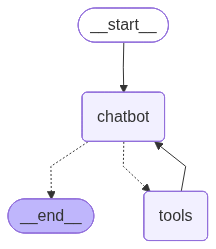

In [10]:

from typing import Annotated

from langchain_tavily import TavilySearch
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

tool = TavilySearch(max_results=2)
tools = [tool, multiply]
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
#graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("tools", END)
graph = graph_builder.compile()
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [11]:
response = graph.invoke({"messages": "What is the latest news in AI and then multiply 2 by 3?"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is the latest news in AI and then multiply 2 by 3?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (e3acd516-cd75-4089-8bea-2fb0500fa891)
 Call ID: e3acd516-cd75-4089-8bea-2fb0500fa891
  Args:
    topic: general
    query: latest AI news
  multiply (0400ef53-e2f4-4b83-a9ef-696b7effb60c)
 Call ID: 0400ef53-e2f4-4b83-a9ef-696b7effb60c
  Args:
    b: 3
    a: 2
================================= Tool Message =================================
Name: tavily_search

{"query": "latest AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.wsj.com/tech/ai?gaa_at=eafs&gaa_n=ASWzDAh4I1eRMfYP1lJmIDO4XJ7QEbwSJT0ojEH3aDdJSANbWlO6vfBv3hU1&gaa_ts=68ecedfe&gaa_sig=RDlzY-QEsqiZSTdMe59N3H8967wnp5KqttgoeHyXcSGtyI3Jb5KTmQFKNhPiKicDOrLLZ6wmO0HJgAn2NwbMxA%3D%3D", "title": "Artificial Intelligence - Latest AI News and 